In [328]:
import os
import glob
import pickle

DIR = "regions"
dig_classes = 10

def get_files():
    return glob.glob(os.path.join(DIR, "*.png"))

f_names = get_files() 

print(f_names.__len__())

5998


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [22]:
print(f_names[0])

regions/1602138135_d3603a.png


In [23]:
# generating number labels
def get_label(f_name):
    return f_name.split("/")[1].split("_")[0]
labels = list(map(get_label, f_names))
print(labels[0])

1602138135


In [24]:
# checking number lengths
digit_lengths = set(map(len, labels))
print(len(digit_lengths), digit_lengths)

3 {8, 9, 10}


In [25]:
# digit map marking every digit in image_n, digit_pos tuple
digit_map = {i:[] for i in range(dig_classes)}

for i, digits in enumerate(labels):
    for j, dig in enumerate(digits):
        digit_map[j].append((i, j))

(array([ 11818.,  10962.,   6582.,   4409.,   3507.,   3460.,   7687.,
          3303.,   3507.,   3618.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

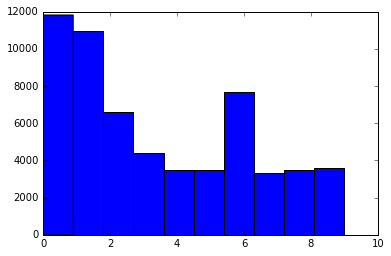

In [288]:
# creating digit frequencies to draw histogram to investigate class balance
digit_hist = [(i, len(digit_map[i])) for i in range(dig_classes)]
digits, d_freq = zip(*digit_hist)

from itertools import chain

plt.hist(list(map(lambda x: int(x), chain(*list(map(list, labels))))))

In [27]:
import cv2
images = list(map(cv2.imread, f_names)) # BGR format
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

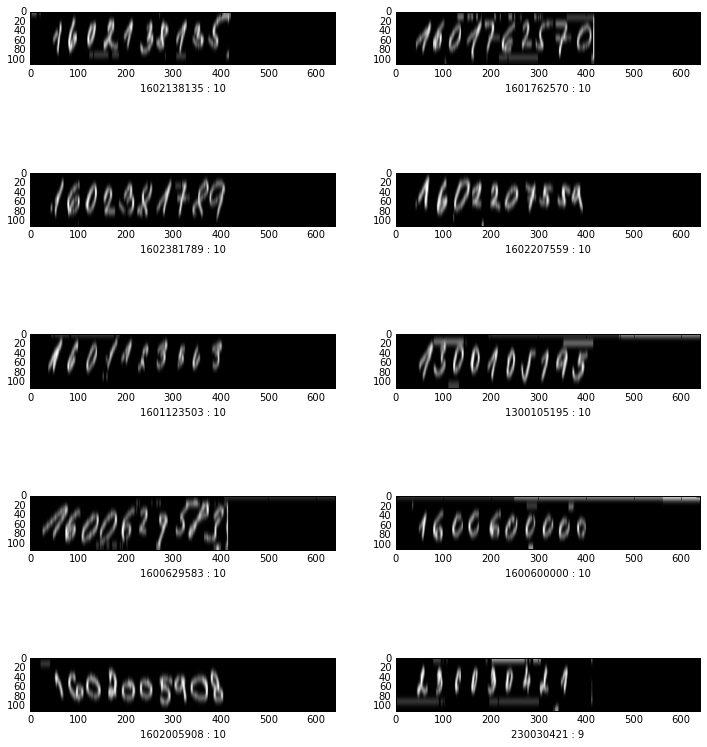

In [28]:
def gen_subplot_group(n, cols=2, size=1.0, colsize=1.0, yield_group=1):
    """generates index, axes tuple from figure subplots
        generates `yield_group` axes at once
    """
    rows = n//cols
    row_size_mul = 1.4 * size
    col_size_mul = 6 * colsize
    fig = plt.figure(figsize=(int(cols*col_size_mul), int(rows*row_size_mul)))
    group = []
    for i in range(1, rows*cols+1):
        ax = fig.add_subplot(rows, cols, i)
        group.append(ax)
        if len(group) == yield_group:
            yield ((i//yield_group)-1, group)
            group = []

def draw_images(images, labels, gray=False, to_rgb=True, n=10, gauss_blur_kernel=(3, 3)):
    """
    draws `n` images in graymap/converting to RGB from BGR
    gray and to_rgb are mutually exclusive
    
    `gauss_blur_kernel`: (x, y) use Gaussian blur with this kernel size to remove noise 
        with a Gaussian filter. x & y must be odd.
    """
    for i, axes in gen_subplot_group(n, size=2.0):
        ax = axes[0]
        args = [cv2.GaussianBlur(images[i], gauss_blur_kernel, 0), ] # cv2.GaussianBlur(gray,(3,3), 0)
        args = [cv2.threshold(images[i], 200,255,cv2.THRESH_BINARY_INV)[1], ]
        args = [cv2.GaussianBlur(args[0], gauss_blur_kernel, 0), ]
        args[0] = cv2.resize(args[0], (0, 0), fx=2.0, fy=3.0)
        # check inverting image instead of thesh
        kwargs = {}
        if gray: 
            kwargs["cmap"] = "gray"
        elif to_rgb: 
            args[0] = args[0][:, :, ::-1]
        plt.imshow(*args, **kwargs)
        ax.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
        
        
draw_images(images_gray, labels, gray=True, gauss_blur_kernel=(1, 11))

1602138135
1601762570
1602381789
1602207559
1601123503
1300105195
1600629583
1600600000
1602005908
230030421


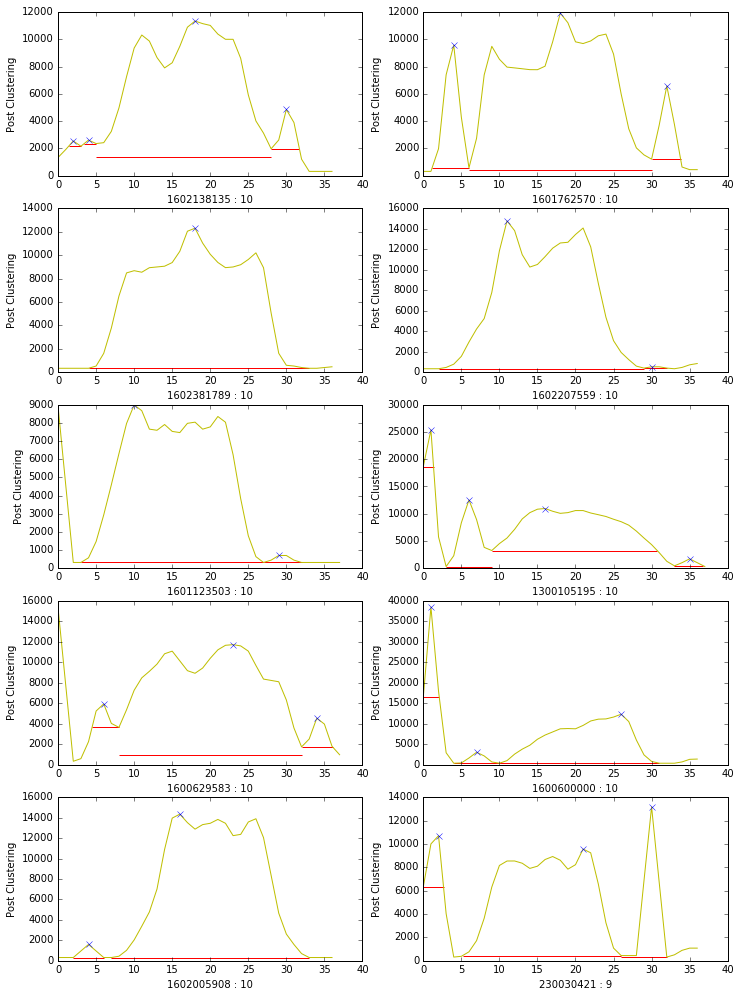

In [91]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

def cluster_peaks(x, peaks, peak_prom, width_results, max_width_only=False, threshold=0.5):
    """
    unsupervised clustering of peaks
    merges overlapping peaks after applying prominence threshold
    suppresses local minima in signals

    Args:
        `peaks`: peak indices
        `peak_prom`: peak prominences
        `width_results`: peak width results from scipy.signal.peak_widths
        `max_width_only`: if True, returns only maximum width peak after merging

    Creates `peak_stats`: format: [(p_i, p_prom, w, w_h, st, en), ...]
            tuples of (peak_indices, peak_prominences, peak_width, peak_base_height, start, end

    Returns:
        `peak_stats` in separated format: 
            peak_indices, peak_prominences, peak_width, peak_base_height, start, end

    # TODO: optimize by using merged candidate bool map instead of delete from array
            optimize by changing presort according to start, end to find candidates faster
            optimize for noise filtering: filter peaks that are on edges
            optimize data contract binding: remove unneccary use of zip/map and improve data interoperability
    """
    # changing zipped tupples to list for mutability
    peak_stats = list(map(lambda x: list(x), zip(peaks, peak_prom, *width_results)))
    peak_stats.sort(key=lambda x: x[2], reverse=True) # sort peaks by width
    # peaks should be merged with a parent peak of minimum width, hence sorting is required
    # TODO: recheck efficient deletes creating dict array for O1 deletes
    # peak_dict = {i: peak_stat for i, peak_stat in enumerate(peak_stats)}
    count = len(peak_stats)

    def remove_cand_from_cur(cur, cand):
        """Removes overlapping but unmergable candidate peak from current peak"""
        # change current's width and remove candidate width from it
        # Note: changes to cur will be reflected in peak_stats list as cur is a list object
        if cand[0] > cur[0]:
            # candidate is right of cur, change cur_end to cand_start
            cur[-1] = cand[-2]
        else:
            # candidate is left of cur, change cur_start to cand_end
            cur[-2] = cand[-1]
        cur[2] = cur[-1] - cur[-2]

    for i in reversed(range(len(peak_stats)-1)):
        cur = peak_stats[i]
        merged = []
        # iterating through every peak with width less than that of current peak
        # to find merge candidates
        for j in range(i+1, count):
            cand = peak_stats[j]
            # if start and end of candidate peak lies between start and end of current peak
            # try to merge with current after applying threshold


            if cand[-2] >= cur[-2] and cand[-1] <= cur[-1]:
                # if prominence height of candidate is less than threshold fraction
                # of that of current peak -> merge
                if cand[1] < threshold * cur[1]:
                    # if base height of candidate is atleast threshold fraction of cur peak height
                    # implies candidate peak is close to current peak in height
                    if cand[3] >= x[cur[0]] * (1 - threshold):
                        merged.append(j)
                    else:
                        # can't merge candidate peak, removing it's edges from current peak
                        remove_cand_from_cur(cur, cand)
                else:
                    # peaks can't be merged, calculate true width of current
                    t_cur_w = cur[2] - cand[2]
                    # find if current peak is left or right of candidate
                    if cur[0] > cand[0]:
                        # current is right of cand, true width is cur_end - cand_end
                        t_cur_w = cur[-1] - cand[-1]
                    else:
                        # current is left of cand, true width is cand_start - cur_start
                        t_cur_w = cand[-2] - cur[-2]
                    # if true width of current is less than candidate, merge current into candidate
                    # while trimming any non-overlapping edges -> just delete current instead
                    if t_cur_w < cand[2]:
                        pass
                        # TODO: merge current? remove false peak: narrow but peakier? 
                        # merged.append(i)
                    remove_cand_from_cur(cur, cand)


        # performing merge: just removing merged candidates from peak_dict
        # sorting merge list to delete largest index first
        merged.sort(reverse=True)
        for j in merged:
            del peak_stats[j]
            count -= 1
            
    if max_width_only:
        peak_stats = [max(peak_stats, key=lambda x: x[2]), ]

    return list(zip(*peak_stats))
        
def process_projection_peaks(x, ax=None, ax_plot_diff=None, *args, **kwargs):
    """Finds peaks in projection, clusters them according to prominence and returns
        can also plot signal (pre/post clustering) as per axes provided
    Args:
        `x`: 1D projection of signal
        `ax`: plt axis to visualize peaks post clustering
        `ax_plot_diff`: plt axis to visualize peaks pre clustering
    Returns:
        `res`: [peaks, peak_widths_l, peak_base_heights, starts, ends]
    """
    def plot_peaks(ax, peaks, width_res):
        ax.plot(x, color="y")
        ax.plot(peaks, x[peaks], "x")
        ax.hlines(*width_res[1:], color="red")
        
        
    peaks, _ = find_peaks(x)
    peak_prom = peak_prominences(x, peaks)[0]
    width_res = peak_widths(x, peaks, rel_height=1)
    # format: p_i, p_prom, w, w_h, st, en
    
    if ax_plot_diff:
        plot_peaks(ax_plot_diff, peaks, width_res)
        ax_plot_diff.set_ylabel("Pre Clustering")
    
    # TODO: DEBUG
#     try:
    peaks, peak_prom, peak_widths_l, peak_base_heights, starts, ends = cluster_peaks(x, peaks, peak_prom, width_res, *args, **kwargs)
#     except Exception as e:
#         print(x, peaks, peak_prom, width_res, args)

    res = [peaks, peak_widths_l, peak_base_heights, starts, ends]
    if ax:
        peaks = np.array(peaks)
        plot_peaks(ax, peaks, list(res[1:]))
        ax.set_ylabel("Post Clustering")
        
    return res

def plot_projections(images_gray, labels=None, n=10, axis=1, plot_diff=False, *args, **kwargs):
    """plots vertical/horizontal projections (sum of pixels) for grayscale images
        after performing peak clustering 
        # TODO: documentation
    """    
    if plot_diff:
        n = 2*n

    for i, axes in gen_subplot_group(n, size=2.5, yield_group=(1+plot_diff)):
        # TODO: streamline experimental image pre processing pipeline
        ret, thresh = cv2.threshold(images_gray[i], 200, 255,cv2.THRESH_BINARY_INV)
        blur_img = cv2.GaussianBlur(thresh, (5, 3), 0)
        
        # TODO: deprecated. 
        # scaled_image = (images_gray[i]) / 255
        
        # scaling image for better visualizations
        scaled_image = blur_img - 255
        project = np.sum(scaled_image, axis=axis)
        
        process_projection_peaks(project, *reversed(axes), *args, **kwargs)
            
        print(labels[i])
        
        for ax in axes:
            ax.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
            
plot_projections(images_gray, labels, axis=1)

1602138135
1601762570
1602381789
1602207559
1601123503
1300105195
1600629583
1600600000
1602005908
230030421


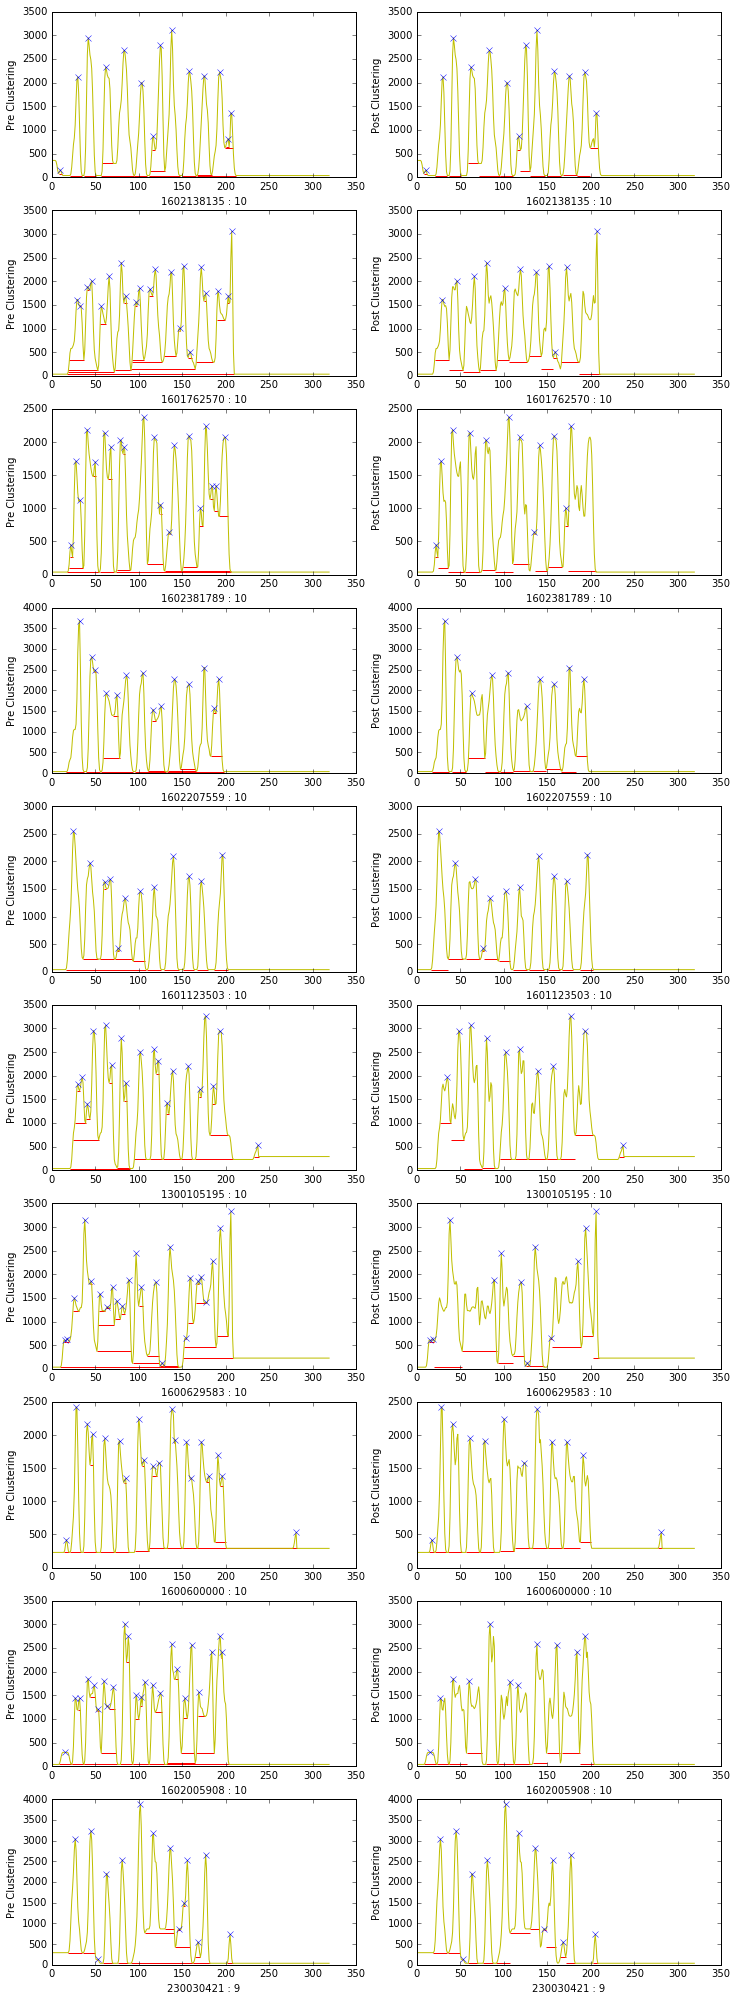

In [30]:
plot_projections(images_gray, labels, axis=0, threshold=0.65, plot_diff=True)

In [267]:
class Box(object):

    OVERLAP_X_EXTEND = 0 # pixels to virtually extend width to consider overlap
    
    def __init__(self, box):
        if type(box) is Box:
            self.box = box.box
        else:
            self.box = box

    def __str__(self):
        return "Box(x:{}, y:{}, w:{}, h:{})".format(*self.box)

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        """for sorting and box comparisions, comparing by x coordinate"""
        return self.box[0] < Box.get_box_obj(other).box[0]

    def __add__(self, other):
        """other can be instance of MergedBox/Box or list of box coordinates
        Note: destroys constituent boxes!
        """
        return self.merge(Box.get_box_obj(other))

    def __getitem__(self, key):
        return self.box[key]
    
    @staticmethod
    def merge_boxes(box1, box2):
        """merge boxes by taking max/min bounds to encompass largest area"""
        x1, y1, w1, h1 = box1
        xe1 = x1+w1
        ye1 = y1+h1
        x2, y2, w2, h2 = box2
        xe2 = x2+w2
        ye2 = y2+h2
        xn, yn, xen, yen = min(x1, x2), min(y1, y2), max(xe1, xe2), max(ye1, ye2)
        return xn, yn, xen-xn, yen-yn

    def merge(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: which .box? parent vs child
        return Box(Box.merge_boxes(self.box, b_obj.box))

    def diff(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: implement
        pass

    def split(self, x, pixel_gap=0):
        """Split this box by provided x coordinate, if x lies in between box bounds, 
                and return two new `Box` instances
        
        `pixel_gap`: artificial gap introduced between the two new boxes, equally divided into both

        Returns 2 `Box` instances in sorted order by x coordinate

        Note: if x lies on Box boundaries, box is not split and the 
            `x` equivalent boundary side (left/right) of the return values is `None`
        """
        if self[0] < x < self[2] + self[0]:
            coor_l = list(self[:])
            coor_r = list(self[:])
            
            coor_l[2] = x - coor_l[0] - pixel_gap//2 - pixel_gap%2
            if coor_l[2] < 0:
                coor_l[2] = 0
            
            coor_r[0] = x + pixel_gap//2
            coor_r[2] = (self[0] + coor_r[2]) - coor_r[0]
            if coor_r[2] < 0:
                coor_r[2] = 0
                coor_r[0] = (self[0] + self[2])

            return Box(coor_l), Box(coor_r)
        elif self[0] == x:
            return None, self
        elif self[2] + self[0] == x:
            return self, None     
        else:
            raise ValueError("`Box` can't be split by unenclosed `x` value")

    def area(self):
        return self.box[-1] * self.box[-2]
    
    @staticmethod
    def overlap_calc(b1, b2, thresh=True):
        """horizontal overlap, negative implies there is distance between boxes"""
        
        if (b1[0] < b2[0]):
            prev = b1
            nx = b2
        else:
            prev = b2
            nx = b1
        x1, y1, w1, h1 = prev
        x2, y2, w2, h2 = nx    
        res = x1 + w1 + (Box.OVERLAP_X_EXTEND if thresh else 0) - x2
        # if x2 < x1:
        #     # implies b2 is behind b1
        #     return -res
        return res
    
    @staticmethod
    def get_box_obj(b_obj):
        # Note: implicit conversion of MergedBox instance to Box by taking superbox
        if type(b_obj) is MergedBox:
            box = b_obj.box
        elif type(b_obj) is Box:
            box = b_obj
        else:
            # assuming b_obj is a tuple of box coordinates
            box = Box(b_obj)
        return box

    def overlap(self, b_obj, thresh=True):
        """overlap between box objects"""
        b1 = self.box
        b2 = Box.get_box_obj(b_obj).box
        return Box.overlap_calc(b1, b2, thresh)



class MergedBox(object):
    """MergedBox class to facilitate merging and holding multiple bounding box coordinates
    
    heirarchial structure: may hold multiple Box/MergedBox objects
    
    class design has been focused on seamless interoperability beween Box and MergedBox 
        instances in terms of add/merge, area and overlap computations
    """
    
    
    OVERLAP_X_THRESH = 0.5 # fraction of width overlap required to consider merging

    MAX_WIDTH = 70 # max acceptable digit width
    MAX_HEIGHT = 33 # max acceptable digit height 

    def __str__(self):
        return "MergedBox(x:{}, y:{}, w:{}, h:{})".format(*self.box.box)

    def __repr__(self):
        return self.__str__()
    
    def __lt__(self, other):
        """for sorting and box comparisions, comparing by x coordinate
        # `other` may be instance of Box/MergedBox
        """
        return self.box < MergedBox.get_mbox_obj(other).box

    def __getitem__(self, key):
        """Access internal boxes directly"""
        return self.boxes[key]

    def __iter__(self):
        """Provides iteraton across sorted sequence of internal boxes"""
        self.sort()
        return self.boxes

    @property
    def box(self):
        # optimized via caching results, check correctness, add tests
        if self.cached:
            return self._res
        
        self._res = self.internal_merge()
        self.cached = True
        return self._res
    
    @box.setter
    def box(self, boxes):
        # boxes has to be list of objects which may be instances of Box/MergedBox
        self.cached = False
        self.boxes = boxes
        
    def __init__(self, boxes=[]):
        """boxes can be MergedBox/Box instance, list of Box/MergedBox instances, list of tuples of box coordinates, or single tuple of box coordinates"""
        # TODO: box label encapsulation, update in init args, add, sub
        # TODO: add support to hold peaks
        
        if type(boxes) is MergedBox:
            boxes = boxes.boxes
        elif type(boxes) is Box:
            boxes = [boxes, ]
        elif boxes:
            if ((type(boxes[0]) is not tuple) and (type(boxes[0]) is not list)):
                # if boxes is non empty and first element of boxes is non iterable, implies: boxes is single
                # tuple of coordinates or boxes is list of Box/MergedBox objects            
                if type(boxes[0]) not in [MergedBox, Box]:
                    # implies boxes is single list of coordinates
                    boxes = [Box(boxes), ]
            else:
                # implies boxes is a nested list of coordinates 
                boxes = list(map(Box, boxes))
        
            # deprecated.
            # raise TypeError("argument `boxes` has to be list of tuples of box coordinates")
        
        self.cached = False # marks if self.box is computed
        self.boxes = boxes 
    
    @staticmethod
    def get_box_list(b_obj):
        if type(b_obj) is MergedBox:
            boxes = b_obj.boxes
        elif type(b_obj) is Box:
            boxes = [b_obj, ]
        else:
            pass
            # deprecated.
            # assuming b_obj is a tuple of box coordinates
            # boxes = [Box(b_obj), ]
        return boxes

    @staticmethod
    def get_mbox_obj(b_obj):
        if type(b_obj) is MergedBox:
            return b_obj
        else:
            return MergedBox(b_obj)

    def __add__(self, b_obj):
        """b_obj can be instance of MergedBox/Box

        # TODO: modify add behaviour: 
        """
        # return MergedBox(self.boxes + MergedBox.get_box_list(b_obj))
        
        # self.boxes.append(b_obj)

        return MergedBox(self.boxes + [b_obj, ])

    
    def __sub__(self, b_obj):
        """b_obj can be instance of MergedBox/Box or list of box coordinates"""
        # assuming common box elements are same array objects
        
        # check if b_obj is in list and pop and return 
        # if b_obj in self.boxes:
        #     self.boxes.remove(b_obj)
        #     return self

        boxes = list(self.boxes)
        if b_obj in boxes:
            boxes.remove(b_obj)
            return MergedBox(boxes)

        return MergedBox(list(set(self.boxes).difference(MergedBox.get_box_list(b_obj))))


    def internal_merge(self):
        # TODO: optimize by batch max/min
        if not self.boxes:
            return Box([0, 0, 0, 0])
        cur = self.boxes[0]
        if type(cur) is MergedBox:
            cur = cur.box
        for i in range(1, len(self.boxes)):
            nx = self.boxes[i]
            if type(nx) is MergedBox:
                nx = nx.box
            cur = cur.merge(nx)
        return cur

    def merge(self, b_obj):
        # Note: destroys constituent boxes!
        # TODO: which .box? parent vs child
        return self + b_obj
    
    def varea(self):
        """virtual area -> of the superbox encompassing all constituent boxes, is an overestimation and may include noise"""
        return self.box.area()
    
    def area(self):
        """actual area of Box by adding constituent box areas"""
        return sum(map(lambda b: b.area(), self.boxes))
    
    def sort(self):
        # TODO: implement caching
        # sort all internal boxes as per `x` start
        self.boxes.sort()
    
    def overlap(self, b_obj, thresh=True):
        """overlap between MergedBox objects
        simple horizontal overlap logic: upgrade to vertical overlap or 
            fragmented `true` overlap as MergedBox constitutents may be discontinous


        `b_obj` can be MergedBox/Box instance or coordinate list as Box.overlap takes care of this
        """
        return self.box.overlap(b_obj.box, thresh)
    
    def best_overlap(self, b1_obj, b2_obj, thresh=True):
        """useful func for merging box with adjacent boxes in sorted list"""
        if self.overlap(b1_obj, thresh) > self.overlap(b2_obj, thresh):
            return b1_obj
        return b2_obj
    
    def ioverlaps(self):
        """calculates array of overlaps between sorted internal boxes"""
        self.sort()
        overlaps = []
        if not self.boxes:
            return overlaps
        bp = self.boxes[0]
        for b in range(1, len(self.boxes)):
            overlaps.append(bp.overlap(self.boxes[b]))
            bp = self.boxes[b]
        return overlaps
    
    def can_merge(self, b_obj):
        """returns whether merge possible with b_obj after applying overlap threshold

        # TODO: add param threshold fraction / absolute
        """
        overlap = self.overlap(b_obj)
        # if overlap > width threshold of current box or candidate box: perform merge
        if (overlap >= self.box[2] * MergedBox.OVERLAP_X_THRESH) or (overlap >= b_obj.box[2] * MergedBox.OVERLAP_X_THRESH):
            return True
        return False

    def flatten(self):
        """flattens the tree heirarchy (Nested `MergedBox`(s) instances in `boxes` member) and outputs the leaves as box coordinates `[x, y, w, h]`"""
        flat = []
        for box in self.boxes:
            if type(box) is MergedBox:
                flat.extend(box.flatten())
            else:
                flat.append(box)
        return flat

    def recursive_tree_split(self, x):
        """Splits the entire tree by x value into two distinct trees

        Doesn't create new boxes unless x lies in between the bounds of a leaf node
        This methods preserves Heirarchial information
        """
        self.sort()
        split_i, bl, br = None, None, None # split index, box_left, box_right

        for i, el in enumerate(self.boxes):
            # comparing by x coordinate only, taking first containing unit
            if el.box[0] <= x <= el.box[0] + el.box[2]:
                if type(el) is MergedBox:
                    bl, br = el.recursive_tree_split(x)
                else:
                    # Found atomic split location!
                    # This is an instance of Box class
                    bl, br = el.split(x, pixel_gap=1)
                split_i = i
                break
            elif el.box[0] < x:
                # handling disjoint fragmented boxes member case
                bl = i
            elif el.box[0] > x and (br is None):
                # handling disjoint fragmented boxes member case
                br = i

        if split_i is not None or (bl is not None and br is not None):
            if split_i is not None:
                # skipping ith element is left or right as it has been split into two
                boxes_l = self.boxes[:split_i] + ([bl, ] if bl else [])
                boxes_r = ([br, ] if br else []) + self.boxes[split_i+1:]
            else:
                boxes_l = self.boxes[:bl+1]
                boxes_r = self.boxes[br:]
                # TODO: remove debug output
                if br > bl + 1:
                    print("\n \n @Tree Split Anomally Detected! \n \n")
            left, right = [(MergedBox(boxes) if boxes else None) for boxes in [boxes_l, boxes_r]]
            return left, right
        else:
            raise ValueError("`MergedBox` can't be split by unenclosed `x` value")

    def get_split_scores(self, split_scorer_func=None, peaks=None, project=None, peak_widths_l=None, peak_base_heights=None):
        """
        split scorer func: returns score or True to split from here?
        """
        flat = self.flatten()
        flat.sort()
        from scipy import stats
        z_score_widths, z_score_heights = [stats.zscore(param) for param in zip(*list(map(lambda x: (x[2], x[3]), flat)))]
        heights = list(map(lambda x: x[3], flat))
        widths = list(map(lambda x: x[2], flat))
        h_mean, h_std = np.mean(heights), np.std(heights)
        w_mean, w_std = np.mean(widths), np.std(widths)
        distances = []
        rel_heights = []
        peak_counts = []
        peak_imp = []
        # TODO: push import to top
        # TODO: replace other z score calculations by stats.zscore
        if flat:
            for i in range(1, len(flat)):
                # distance is -ve of overlap
                distances.append(-flat[i-1].overlap(flat[i]))
                rel_heights.append(heights[i-1]/heights[i] if heights[i-1] < heights[i] else heights[i]/heights[i-1])
            
            if peaks:
                p_i = 0
                peaks_in_boxes = []
                for f in flat:
                    (x, y, w, h) = f
                    peaks_in_boxes.append([])
                    while p_i < len(peaks) and peaks[p_i] <= x+w:
                        # check apply higher threshold? use higher gaussian kernel?
                        peak_imp_score = peak_widths_l[p_i] * (project[peaks[p_i]] - peak_base_heights[p_i])
                        if x <= peaks[p_i] <= x+w:
                            peaks_in_boxes[-1].append((peaks[p_i], peak_imp_score))
                        else:
                            # peak wasted!
                            pass
                        p_i += 1
                peak_counts = [len(x) for x in peaks_in_boxes]
                peak_imp = [(int(sum(list(zip(*x))[1])/1) if x else 0) for x in peaks_in_boxes]

        hrep = "Height(Mean: {}, std: {})".format(h_mean, h_std)
        wrep = "Width(Mean: {}, std: {})".format(w_mean, w_std)
        
        # caching results: box report
        self.brep = z_score_widths, z_score_heights, distances, rel_heights, peaks_in_boxes, peak_counts, peak_imp, heights, flat

        return hrep, wrep, z_score_widths, z_score_heights, distances, rel_heights, peak_counts, peak_imp, heights

    def split_node(self, discard_noise=True):
        """divides the box into two boxes by sensible overlap heuristic (minimize overlap?)"""
        dist_thresh = 2
        height_thresh = 0.75
        noise_thresh = 5
        split = False
        x_split = None
        if self.brep:
            # getting box reports previously computed
            z_score_widths, z_score_heights, distances, rel_heights, peaks_in_boxes, peak_counts, peak_imp, heights, flat = self.brep
            if distances:
                bst = np.argmax(distances)
                if bst > dist_thresh:
                    if rel_heights[bst] > height_thresh:
                        x_split = flat[bst].box[0] + flat[bst].box[2]
                        split = True
        if not split:
            # TODO: attempt peakwise split
            # just splitting by half for now
            x_split = self.box[0] + self.box[2]//2

        if x_split is not None:
            b1, b2 = self.recursive_tree_split(x_split)
            if discard_noise:
                if b1.box[2] < noise_thresh: 
                    b1 = None
                elif b2.box[2] < noise_thresh:
                    b2 = None
            return b1, b2

        return None
    
    def distance(self, other):
        """opposite of overlap: convenience function"""
        return -self.overlap(other)

    def cut_from_image(self, image):
        """Cut flattened Box constituents from provided image to generate same size digit training data
        
        Only cuts detected contours with no extra area and minimizes noise added
        
        Returns newly created np array of shape (MergedBox.MAX_WIDTH, MergedBox.MAX_HEIGHT)
        """
        MergedBox.MAX_HEIGHT
        MergedBox.MAX_WIDTH
        x_start = self.box[0]
        y_start = self.box[1]
        width = self.box[2]
        height = self.box[3]
        constituent_boxes = self.flatten()
        
        # Note: image height and width are reversed in numpy as height corresponds to num rows: axis 0
        cut_img = np.zeros(shape=(MergedBox.MAX_HEIGHT, MergedBox.MAX_WIDTH), dtype=np.uint8)

        # dealing with anomally: single digit width > MAX_WIDTH
        if width > MergedBox.MAX_WIDTH:
            print("box width anomally! Truncating box")
            constituent_boxes = [Box([x_start, y_start, MergedBox.MAX_WIDTH, height, ]), ]
            width = MergedBox.MAX_WIDTH
        
        # centering training data
        w_offset = (MergedBox.MAX_WIDTH - width) // 2
        h_offset = (MergedBox.MAX_HEIGHT - height) // 2

        for box in constituent_boxes:
            (x, y, w, h) = box.box
            cut_img[y-y_start+h_offset:y+h-y_start+h_offset, x-x_start+w_offset:x+w-x_start+w_offset] = image[y:y+h, x:x+w]

        return cut_img


    def peaks(self):
        pass
    
    def box_encloses(self, x):
        pass

    def area_thresh(self, area_thresh):
        """applies area threshold on itself and returns Bool
            # TODO: figure out whether to do on superbox or true area?
        """
        pass

In [32]:
b = Box([1, 2, 3, 4])
print((type(b[:])))

<class 'list'>


In [33]:
"""
# TODO: check box filter post merging, prev boxes don't need to be nullified?
        optimize for identical boxes: same tuple by object ID
"""


# Logic
# overlap mergeflatten    def internal_merge(self):

# area filter merge target: ignore or merge (proximity/overlap threshold before merge/ignore)
#     merged noise: separate by distance
# keep top `n` by area?




def merge_routine(bbs, merge_func, passes=2):
    # one way adjacency? as i starts from `0`, already considered `prev` at i > 0?
    # fragmented box best overlap? components instead of super? for true overlap?
    # recursive merge in adjacency window? agglomerative heirachial clustering?
    # collapsing array?
    # retaining heirarchial structure via embedding Box within Box or subclassing Box
    for _ in range(passes):
        bbs.sort()
        # sorting by x coordinate
        for i, b in enumerate(bbs):
            # TODO: merge loops
            merge_func(bbs, i, b)
        bbs = list(filter(lambda x: x, bbs))
    bbs.sort()
    return bbs

def get_merge_func(adjacency_window_size=1, predecessor_only=False, thresh_func=lambda x: True):
    def merge_candidate(bbs, i, b, adjacency_window_size=1):
        lims = (i-adjacency_window_size, i+(adjacency_window_size if not predecessor_only else 0)+1)
        adjacents = [(j, bbs[j]) for j in range(*lims) \
                     if j != i and j>=0 and j<len(bbs) and bbs[j] is not None]

        # for j, b2 in enumerate(adjacents):
        #     pass
        
        if adjacents:
            # best overlap in adjacents
            j, a = max(adjacents, key=lambda x: b.overlap(x[1]))
            
            # TODO: comment architecture philosophy
            if thresh_func(b, a):
            #if b.can_merge(a):
                # pushing merged box in maximum index btw i, j so it may be referenced in subsequent adjacency iterations
                bbs[max(i, j)] = b + a
                bbs[min(i, j)] = None
    return merge_candidate


In [34]:
b = MergedBox([[1, 1, 2, 2], [4, 4, 1, 1], ])      
print(b.ioverlaps())

bbs = [b, ]

def box_merge_routines(bbs):
    ###
    # Box merge routines: overlap threshold
    ###
    
    thresh_func = lambda x, y: x.can_merge(y)
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)
    
    ###
    # Box merge routines: area Gauss filter, overlap threshold and best adjacent merge
    ###
    
    areas = list(map(lambda x: x.varea(), bbs))
    mean_a = np.mean(areas)
    std_a = np.std(areas)
    thresh_a = mean_a - std_a

    thresh_func = lambda x, y: (x.area() <= thresh_a or y.area() <= thresh_a) and (x.overlap(y) > -2)
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)


    thresh_func = lambda x, _: x.area() <= thresh_a - std_a*0.75
    merge_function = get_merge_func(thresh_func=thresh_func)
    bbs = merge_routine(bbs, merge_func=merge_function, passes=1)

    return bbs
    
box_merge_routines(bbs)

[-1]


[MergedBox(x:1, y:1, w:4, h:4)]

In [149]:
ALPHA = True
AREA_FILTERS = True
AREA_FILTERS_2 = True

Y_AXIS_PROJECTION_DEF_THRESHOLD_PREV = 0.5 # has bugs: see end of file section
Y_AXIS_PROJECTION_DEF_THRESHOLD_TEST = 0.57
def filter_horizontal_noise_yaxis_projection(project_img, mask_img):
    project = np.sum(project_img, axis=1)
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project,
                                                                                     threshold=Y_AXIS_PROJECTION_DEF_THRESHOLD_TEST)
    
    mx_w_ind = np.argmax(peak_widths_l)
    st, en = starts[mx_w_ind], ends[mx_w_ind]
    
    # masked = np.copy(thresh)
    mask_img[:st, :] = 0
    mask_img[en:, :] = 0
    
def filter_vertical_noise_xaxis_projection(project_img, mask_img):
    project = np.sum(project_img, axis=0)
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project, threshold=0.65)
    mean_width = np.mean(peak_widths_l)
    mean_height = np.mean(list(map(lambda x: project[x], peaks)))
#     print("height: ", mean_height)
    peak_stats = list(zip(peaks, peak_widths_l, starts, ends))
    peak_stats.sort(key=lambda x: x[2] * 10000 + x[3])
    # high peak candidates are more important to be removed
    # apply peak threshold
    rem_cand = peak_stats[:5] + peak_stats[-5:] # only take edge candidates for removal
    rem_cand.sort(key=lambda x: x[1]) # sort candidates by width candidates
#     rem_cand = rem_cand[:2] # take first two least width candidates
#     print("shape", img_g.shape[1] / 2)
#     print("mean width: ", mean_width)
    for cand in rem_cand:
#         if labels[i] == "1300105195":
#             print("mean widht: ", mean_width, ", mean height: ", mean_height)
#             print("cand: ", cand, ", height: ", project[cand[0]])
        # if candidate width is less than half of mean_width
        # remove candidate from image
        # TODO: hyperparameters
        if 0 <cand[1] < 0.6 * mean_width and mean_height * 1.5 < project[cand[0]]:
            # if candidate is on left of image
            if cand[-1] < (project_img.shape[1] / 2):
                mask_img[:, cand[-2]:cand[-1]] = 0
            # else candidate is on right of image
            else: 
                # TODO: merge filters
                mask_img[:, cand[-2]:cand[-1]] = 0

def get_contour_bounding_boxes(img, draw_img=None):
    im2, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for (k, c) in enumerate(contours):
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # only accept the contour region as a grouping of characters if
        # the ROI is sufficiently large
        if w >= 2 and h >= 2:
            boxes.append((x, y, w, h))
            if draw_img is not None:
                cv2.rectangle(draw_img, (x,y), (x+w, y+h), (255,0,0), 1)
    return boxes

def filter_by_dips(filter_targets):
    """filter boxes by maximum dips in sorted box split scores
    
    Deprecated.
    """
    filter_targets.sort(key=lambda x: x[0][0], reverse=True)
    
    dips = [0, ]
    for i in range(1, len(filter_targets)):
        dips.append(filter_targets[i-1][0][0] - filter_targets[i][0][0])   
    cands = filter_targets[:np.argmax(dips)] # split by max dip in stats
    
    # cands = filter_targets[:5] # truncate to get candidates
    
    cands.sort(key=lambda x: x[0][1], reverse=True)
    dips = [0, ]
    for i in range(1, len(cands)):
        dips.append(cands[i-1][0][1] - cands[i][0][1])
    
    cands = cands[:np.argmax(dips)]
    return cands

def get_box_reports(clone_masked, bbs):
    blurred_clone = cv2.GaussianBlur(clone_masked, (3,3), 0)
    canny_res = cv2.Canny(blurred_clone, 300, 900)
    project = np.sum(canny_res, axis=0) # clone_masked
    peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project, threshold=0.75)
    # TODO: machine learning n_peaks -> dual digits
    peaks = sorted(peaks)
    peaks_in_boxes = []
    wasted_peaks = []
    p_i = 0
    
    bbs.sort()
    boxes = list(map(lambda x: x.box.box, bbs))
    
    # TODO: optimization: b_widths from find contour bounding boxes
    b_widths = list(map(lambda x: x[2], boxes))
#     b_heigh = list(map(lambda x: x[3], boxes))
    w_mean, w_std = np.mean(b_widths), np.std(b_widths)
    breps = []
    for box, bb in zip(boxes, bbs):
        
        ####### Split candidate stats
        brep = bb.get_split_scores(peaks=peaks,
                                         project=project,
                                         peak_widths_l=peak_widths_l,
                                         peak_base_heights=peak_base_heights)
        breps.append(brep)

        peaks_in_boxes.append([])
        (x, y, w, h) = box
        w_z_score = (w-w_mean) / w_std
        if w_z_score < 0:
            w_z_score = 0
        while p_i < len(peaks) and peaks[p_i] <= x+w:
            # check apply higher threshold? use higher gaussian kernel?
            peak_imp_score = w_z_score*10#peak_widths_l[p_i] * (project[peaks[p_i]] - peak_base_heights[p_i])
            if x <= peaks[p_i] <= x+w:
                peaks_in_boxes[-1].append((peaks[p_i], peak_imp_score))
            else:
                wasted_peaks.append(peaks[p_i])
            p_i += 1
    
    while p_i < len(peaks):
        wasted_peaks.append(peaks[p_i])
        p_i += 1
    return breps, peaks_in_boxes
import math
def get_split_scores(breps, peaks_in_boxes):
    # needs: peaks_in_boxes, breps; returns scores
    peak_counts_l = [len(x) for x in peaks_in_boxes]
    # BUG: nan float to int
    peak_imp_l = []
    for x in peaks_in_boxes:
        cur = 0
        if x:
            cur = sum(list(zip(*x))[1])/1
            if not math.isnan(cur):
                  cur = int(cur)
        peak_imp_l.append(cur)
#     peak_imp_l = [(int(sum(list(zip(*x))[1])/1) if x else 0) for x in peaks_in_boxes]
    peak_counts_s = ""
    scores = []
    for j, b in enumerate(breps):
        hrep, wrep, z_score_widths, z_score_heights, distances, rel_heights, peak_counts, peak_imp, heights = b
        dscore = max(distances) if distances else 0
        relscore = min(rel_heights) if rel_heights else 0
        bcount = len(distances)
        hscore = np.sum(heights)
        
        score_1 = peak_counts_l[j]*10 + peak_imp_l[j]
        score_2 = dscore/3 + bcount*13 + hscore*0.7 + relscore*10

        scores.append((score_1, score_2, j))
        
        # peak_counts_s += "|{:.0f}:{:.0f}:{:.0f}:{:.0f}:{:.0f}:{:.0f} ".format(peak_counts_l[j]*3, peak_imp_l[j]/2, dscore/3, bcount*13, hscore*0.7, relscore*10)
    return scores

def filter_boxes(filters):
    # needs: filters, returns cands, peak_counts_s (test label)
    # from sklearn.preprocessing import MinMaxScaler
    # r = MinMaxScaler()
    y = list(map(lambda x: x[2], filters))
    X = np.array(list(map(lambda x: (x[0], x[1]), filters)))
    
    x_mean = np.mean(X, axis=0)
    x_std = np.std(X, axis=0)
    zscores = (X - x_mean) / x_std
#     filters = list(r.fit_transform(X))
    filters = list(zip(filters, zscores))

    cands = filters # filter_by_dips(filters)
    
    cands = list(filter(lambda x: x[0][0] > 50 and x[0][1] > 45, cands)) # 50, 45 # outlier: (70, 23.8) 45 close
    
    peak_counts_s = "{}".format([("%.2f"%cands[j][0][0], "%.2f"%(cands[j][0][1]), cands[j][0][2]+1) for j, c in enumerate(cands)])

    return cands, peak_counts_s

def box_split_routine(clone_masked, bbs):
    # test: detect multiple peaks in conjoined images:
    breps, peaks_in_boxes = get_box_reports(clone_masked, bbs)
    # generating split scores for every Box from reports
    filters = get_split_scores(breps, peaks_in_boxes)
    
    # filtering boxes based on received scores
    cands, peak_counts_s = filter_boxes(filters)
         
    for cand in cands:
        b_ind = cand[0][2]
        splits = []
        b1, b2 = bbs[b_ind].split_node(discard_noise=True)
        if b1:
            splits.append(b1)
        if b2:
            splits.append(b2)
        
        bbs[b_ind] = splits
    
    bbsnew = []
    for j, bb in enumerate(bbs):
        if type(bb) is list:
            bbsnew.extend(bb)
        else:
            bbsnew.append(bb)
    return bbsnew

def get_digit_bounding_boxes(thresh, blur_img, debug=False, pyplot_axis_res=None, pyplot_axis_prev=None, label=None, return_clone=False):
    # TODO: avoid copying thresh
    masked = np.copy(thresh)
    ###
    # y axis projection
    ###
    filter_horizontal_noise_yaxis_projection(blur_img, masked)
    ###
    # x axis projection
    ###
    filter_vertical_noise_xaxis_projection(blur_img, masked)

    ###
    # Bounding box detection routines
    ###
    
    # TODO: optimization: limit image copies
    # TODO: optimization: reuse Gaussian blurred/thresholded image for digit classification
    clone_masked = masked.copy() # used in box_split_routine
    
    if debug:
        box_filtered = masked.copy() # for drawing bounding boxes
        clone = masked.copy()
    # DEBUG: draw_img: used to compare boxes found, used in get_contour_bounding_boxes
    # TODO: try drawing boxes on gaussian Blurred image instead of thresholded image
        boxes = get_contour_bounding_boxes(masked, draw_img=clone)
    else:
        boxes = get_contour_bounding_boxes(masked)
    
    # ALPHA TEST
    bbs = list(map(MergedBox, boxes))
    bbs = box_merge_routines(bbs)
    ###
    # Box SPLIT routines: canny peaks counts/importance, box width Gauss filter
    ###
    bbs = box_split_routine(clone_masked, bbs)

    if debug:
        
        # DEBUG: image labels
        bbs.sort(key=lambda x: x.area(), reverse=False)
        
        peak_counts_s = "{} vs found: {}, weights_z: {}".format(len(label), str(len(bbs)), list(map(lambda x: math.ceil(x*100)/100, stats.zscore(list(map(lambda x: x.varea(), bbs))))))
        ###
        
        for box in bbs:
            (x, y, w, h) = box.box
            cv2.rectangle(box_filtered, (x,y), (x+w, y+h), (255, 0, 0), 1)
            
        ##########  
        
    #     pyplot_axis.imshow(clone, cmap="gray")
    #     pyplot_axis.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
    #     pyplot_axis.set_ylabel("boxes ori")
        
        pyplot_axis_res.imshow(box_filtered, cmap="gray")
        pyplot_axis_res.set_xlabel(peak_counts_s)

        pyplot_axis_prev.imshow(clone, cmap="gray") # clone, thresh
        pyplot_axis_prev.set_xlabel(label + " : {}".format(len(label)))

    if return_clone:
        return clone_masked, bbs

    return bbs

def image_augmentation_pipeline(image_gray):
    ret, thresh = cv2.threshold(image_gray, 200, 255,cv2.THRESH_BINARY_INV)
    # Gaussian filter will remove noise, kernel size has been optimized by trial and error
    # the x projection has much higher noise fluctuations and is more affected
    # by kernel choices
    blur_img = cv2.GaussianBlur(thresh, (3, 3), 0)

    return thresh, blur_img

def plot_digit_boxes(images_gray, labels, n=30): # debug function
    # TODO: pipeline image transformations and remove repetitive code
    for i, axes in gen_subplot_group(n*2, size=1.0, yield_group=2):
        ax1, ax2 = axes
        img_g = images_gray[i]
        thresh, blur_img = image_augmentation_pipeline(img_g)
        boxes = get_digit_bounding_boxes(thresh, blur_img, debug=True, pyplot_axis_res=ax1, pyplot_axis_prev=ax2, label=labels[i])

        # labels[i] + " : {}".format(len(labels[i])) + " : " + 
        
        # canny_res = cv2.Canny(clone_masked, 300, 900)
        
    #     ax2.set_ylabel("box filtered")
        # any box with 30% or higher overlap in vertical is merged
        # merge smaller below threshold with closest larger

def get_digit_bounding_boxes_baseline(img_thresh, blur_img, thresh=True):
    masked = np.copy(img_thresh)
    ###
    # y axis projection
    ###
    filter_horizontal_noise_yaxis_projection(blur_img, masked)
    ###
    # x axis projection
    ###
    filter_vertical_noise_xaxis_projection(blur_img, masked)

    boxes = get_contour_bounding_boxes(masked)
    boxes = list(map(MergedBox, boxes))

    # TODO: apply area filter
    if thresh:
        areas = list(map(lambda x: x.area(), boxes))
        widths = list(map(lambda x: x.box[2], boxes))

        z_score_areas = stats.zscore(areas)
        z_score_widths = stats.zscore(widths)

        threshold_area = 1.8
        threshold_width = 2
        filter_func = lambda x: abs(z_score_widths[x[0]]) < threshold_width and abs(z_score_areas[x[0]]) < threshold_area
        boxes = list(map(lambda x: x[1], filter(filter_func, enumerate(boxes))))
    
    return boxes


def accuracy_boxes(images_gray, labels, baseline=False):
    """
    20% bounding box detection error rate
    """
    processed = 0
    incorrect = 0
    # get max height and width
    mxw = [0, ]
    mxh = 0

    # TODO: relocate import
    import time
    t1 = time.time()
    for i, (img, lb) in enumerate(zip(images_gray, labels)):
        img_g = images_gray[i]
        thresh, blur_img = image_augmentation_pipeline(img_g)
        if baseline:
            boxes = get_digit_bounding_boxes_baseline(thresh, blur_img)
        else:
            boxes = get_digit_bounding_boxes(thresh, blur_img, debug=False)
        for box in boxes:
            if box.box[2] > mxw[-1]:
                mxw.append(box.box[2])
                mxw.sort()
            if box.box[3] > mxh:
                mxh = box.box[3]
        # Bug:
        # 1602300000_ae61d5.png
        # i = 2509
        # # # ERROR in third projection used for splitting
        # horizontal noise filter removing all digits
        # solution: 
        # works awesome with process_projection_peaks(project, threshold=0.75)

        if len(boxes) != len(labels[i]):
            incorrect += 1
        processed += 1
        if processed % 1000 == 0:
            t2 = time.time()
            print("1000 processed in time: {0:.2f}s".format(t2-t1))
            print("% incorrect: {0:.2f}".format(incorrect/processed*100))
    t2 = time.time()
    print("Net processing time: {0:.2f}s".format(t2-t1))
    print("% NET ERROR RATE: {0:.2f}".format(incorrect/processed*100))
    print("Max width, height of digits: ", mxw, mxh)

# plot_digit_boxes(images_gray, labels)
#accuracy_boxes(images_gray, labels, baseline=True)

def get_separated_digits(image_gray):
    thresh, blur_img = image_augmentation_pipeline(image_gray)
    clone, boxes = get_digit_bounding_boxes(thresh, blur_img, debug=False, return_clone=True)
    digit_images = []
    for box in boxes:
        digit_images.append(box.cut_from_image(clone))
    return digit_images


# plot_digit_boxes(images_gray, labels)
# accuracy_boxes(images_gray, labels)

In [ ]:
bres = [[1, 2, 3, 4]]
print(list(map(str, list(map(MergedBox, bres)))))

In [ ]:
# TODO: pipeline image transformations and remove repetitive code
for i, axes in gen_subplot_group(30):
    ax = axes[0]
    img_g = images_gray[i]
    ret, thresh = cv2.threshold(img_g, 200, 255,cv2.THRESH_BINARY_INV)
#     blur_img = cv2.GaussianBlur(thresh, (3, 3), 0)
    plt.imshow(thresh, cmap="gray")
    ax.set_xlabel(labels[i])

In [ ]:
for (b_heights, b_widths), (i, axes) in zip(zip(bb_heights, bb_widths), gen_subplot_group(len(bb_heights)*2, size=2.5, yield_group=2)):
    print("b height mean: ", np.mean(b_heights), ", b width mean: ", np.mean(b_widths))
    axes[0].plot(b_heights)
    axes[0].set_xlabel("heights")
    axes[1].plot(b_widths)
    axes[1].set_xlabel("widths")

In [210]:
def generate_digit_training_data(images_gray, labels, limit=10, skip_incorrect_data=True, cache=True):
    """genereates separated digits and labels as training data
    
    if `skip_incorrect_data` is set, ignores all numbers for which no. of bounding boxes doesn't match label size

    returns digit images, digit labels and digit unique identifier for saving/referencing
    """
    training_data_pickle_file = "train.pkl"

    if cache and os.path.isfile(training_data_pickle_file):
        with open(training_data_pickle_file, "rb") as fd:
            digit_images, digit_labels, digit_ids, skip_count = pickle.load(fd)
        print("skipped: {}, {}".format(skip_count, skip_count/len(labels)*100))
        return digit_images, digit_labels, digit_ids

    digit_images = []
    digit_labels = []
    digit_ids = []
    skip_count = 0

    if limit is None:
        # take all of data if limit is None
        limit = len(labels)

    for i, (img_g, label) in enumerate(zip(images_gray, labels)):
        if i > limit:
            break
        d_imgs = get_separated_digits(img_g)
        d_labels = list(label)
        d_ids = [] 
        if len(d_labels) != len(d_imgs):
            if skip_incorrect_data:
                skip_count += 1
                continue
            min_len = min(len(d_labels), len(d_imgs))
            d_imgs = d_imgs[:min_len]
            d_labels = d_labels[:min_len]
        # digit identifier to save digit file. In format : <digit_value-(0. 9)> : <number_label> : <digit_index_in_number>
        d_ids = list(map(lambda x: "{}:{}:{}".format(x[1], label, x[0]), enumerate(d_labels)))
        digit_ids.extend(d_ids)
        digit_images.extend(d_imgs)
        digit_labels.extend(d_labels)

    if cache:
        with open(training_data_pickle_file, "wb") as fd:
            pickle.dump([digit_images, digit_labels, digit_ids, skip_count], fd)
    print("Numbers skipped due to inaccuracies: {}, {:.2f}%".format(skip_count, (skip_count/limit)*100))

    return digit_images, digit_labels, digit_ids

In [277]:
digit_images, digit_labels, digit_ids = generate_digit_training_data(images_gray, labels, limit=None, cache=False)

/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: using a non-integer number instead of an int

box width anomally! Truncating box
Numbers skipped due to inaccuracies: 1290, 21.51%


7568
7568
7568


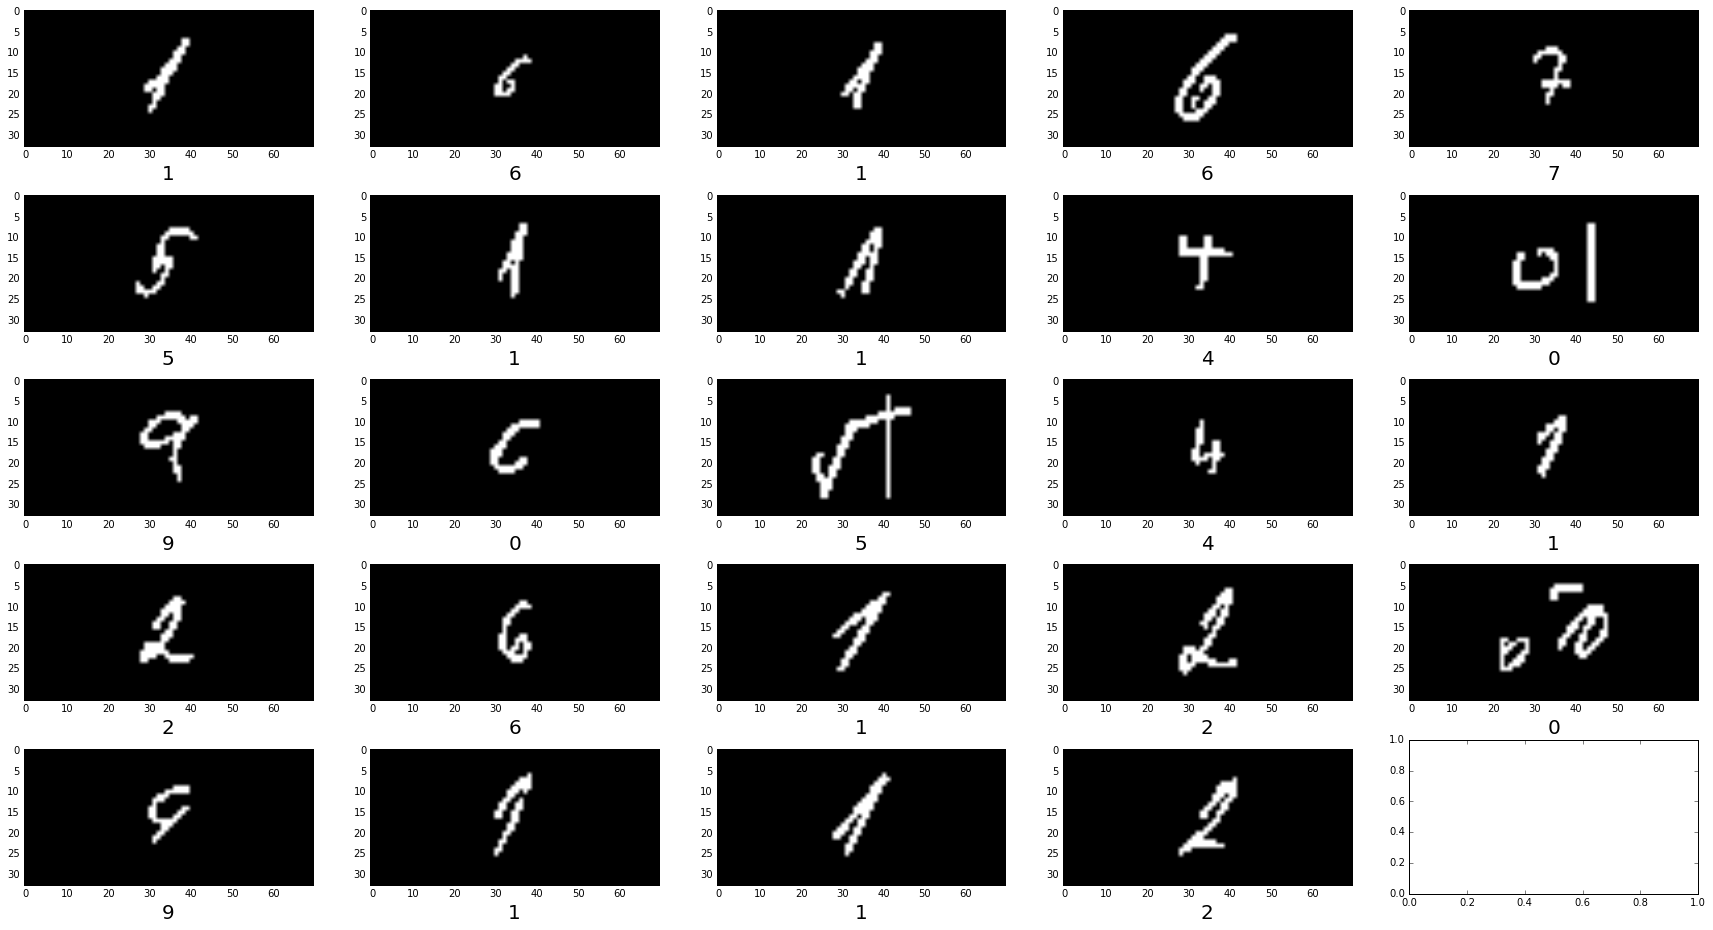

In [227]:
print(len(digit_images))
print(len(digit_labels))
print(len(digit_ids))
def visualize_digits(digit_images, digit_labels):
    data = list(zip(digit_images, digit_labels))
    np.random.shuffle(data)
    for i, axes in gen_subplot_group(25, cols=5, size=2.3, colsize=1.0, yield_group=2):
        for j, ax in enumerate(axes):
            # ax.axis('off')
            ax.imshow(data[i*2+j][0], cmap="gray")
            ax.set_xlabel(data[i*2+j][1], fontsize=20)

(array([ 9280.,  8630.,  5151.,  3501.,  2779.,  2671.,  6006.,  2614.,
         2672.,  2863.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

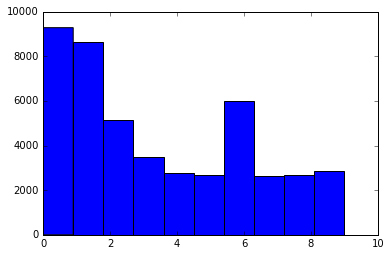

In [280]:
# checking class balance in separated digits
int_labels = list(map(lambda x: int(x), digit_labels))
plt.hist(int_labels)

In [337]:
import time
print(len(digit_images))
print(len(digit_labels))
from sklearn import svm, linear_model, preprocessing, metrics, model_selection, decomposition

# int_labels = list(map(lambda x: int(x), digit_labels))

# X = np.array(digit_images, dtype=np.uint8)
# X = X.reshape(len(digit_images), -1)

# lb = preprocessing.LabelBinarizer()
# lb.fit(int_labels)
# print(lb.classes_)
# y = lb.transform(int_labels)
# print(X.shape)
# print(y.shape)
# y = int_labels


def timeit(func, label=None, verbose=True):
    def func_caller(*args, **kwargs):
        t1 = time.time()
        ret = func(*args, **kwargs)
        t2 = time.time()
        verbose_cur = verbose
        if args:
            try: 
                verbose_cur = args[0].verbose
            except AttributeError as e:
                pass
        if verbose_cur:
            print("time taken for {}: {:.2f}s".format(label if label else func.__name__.upper(), t2-t1))
        return ret
    return func_caller

class DigitClassifier(object):
    
    PCA_N_COMPS = 100
    CACHE_FILE = "pipeline.pkl"
    
    def __init__(self, load_from_cache=False, transformer=None, classifier=None, verbose=True):
        self.transformer = transformer if transformer else decomposition.PCA(n_components=DigitClassifier.PCA_N_COMPS) 
        self.classifier = classifier if classifier else linear_model.LogisticRegression()
        self.predict_ready = False
        self.verbose = verbose
    
    def log(self, msg):
        if self.verbose:
            print(msg)
    
    def save(self):
        with open(DigitClassifier.CACHE_FILE, 'wb') as fd:
            pickle.dump([self.transformer, self.classifier, ], fd)
            self.log("Classifier saved to disk.")
            
    def load(self):
        if self.predict_ready:
            self.log("Classifier is pre-trained and ready to predict.")
            return
        if os.path.isfile(DigitClassifier.CACHE_FILE):
            with open(DigitClassifier.CACHE_FILE, 'rb') as fd:
                self.transformer, self.classifier = pickle.load(fd)
                self.log("classifier loaded from cache file.")
                self.predict_ready = True
                return True
        self.log("Classifier cache file unavailable.")
        return False
    
    def preprocess_data(self, X):
        n_samples = len(X)
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(n_samples, -1)
        return X
    
    def preprocess_transform_data(self, X):
        X = self.preprocess_data(X)
        X = self.transformer.transform(X)
        return X
    
    def preprocess_labels(self, y):
        y = list(map(int, y))
        return y
    
    @timeit
    def train(self, X, y):
        X = self.preprocess_data(X)
        X = self.transformer.fit_transform(X)
        y = self.preprocess_labels(y)
        self.classifier.fit(X, y)
        self.save()
        self.predict_ready = True
    
    def predict(self, X):
        if not self.predict_ready:
            self.load()
        X = self.preprocess_transform_data(X)
        return self.classifier.predict(X)
    
    def predict_single(self, x):
        if not self.predict_ready:
            self.load()
        # TODO: validate
        X = self.preprocess_transform_data([x, ])
        return self.classifier.predict(X)
    
    @timeit
    def evaluate(self, X, y):
        X = self.preprocess_data(X)
        y = self.preprocess_labels(y)
        predicted = self.classifier.predict(X)
        self.log("Classification report for classifier %s:\n%s\n"
              % (self.classifier, metrics.classification_report(y, predicted)))
        self.log("Confusion matrix:\n%s" % metrics.confusion_matrix(y, predicted))
        
    @timeit
    def train_test(self, X, y):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y)
        self.train(X_train, y_train)
        self.evaluate(X_test, y_test)

def train_digit_classifier(images_gray, labels):
    digit_images, digit_labels, digit_ids = generate_digit_training_data(images_gray, labels)
    classifier = DigitClassifier()
    classifier.train(digit_images, digit_labels)

46167
46167


In [340]:
class NumberReader(object):
    
    def __init__(self, digit_classifier=None):
        self.digit_classifier = digit_classifier if digit_classifier else DigitClassifier()
    
    def read_from_grayscale(self, image_gray):
        """image_gray has to be in grayscale"""
        digit_images = get_separated_digits(image_gray)
        predictions = self.digit_classifier.predict(digit_images)
        return "".join(map(str, predictions))
    
    def read_from_image(self, image):
        """image has to be in BGR format"""
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return self.read_from_grayscale(image_gray)
        
    def read_from_filename(self, filename):
        if not os.path.isfile(filename):
            print("file doesn't exist!")
            raise ValueError("incorrect filename.")
        image = cv2.imread(filename) # BGR format
        return self.read_from_image(image)
        
        

In [348]:
nr = NumberReader()

#nr.read_from_filename("regions/20111823_6884a0.png")
count = 0
incorrect = []
correct = []

for i, (img_g, label) in enumerate(zip(images_gray, labels)):
    predicted = nr.read_from_grayscale(img_g)
    if predicted == label:
        correct.append((i, label))
    else:
        incorrect.append((i, label, predicted))
    count += 1
print("incorrect: {} - {}%; count: {}".format(len(incorrect), len(incorrect)/count*100, count))

/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


classifier loaded from cache file.


/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


box width anomally! Truncating box
incorrect: 4796 - 79.95998666222074%; count: 5998


In [347]:
cc = 0
for i, (img_g, label) in enumerate(zip(images_gray, labels)):
    cc += 1
print(cc)
print(len(images_gray))

5001


In [275]:
classifier.predict_proba(X_test[:5])

array([[  4.46513103e-02,   2.05730912e-04,   4.82850530e-02,
          3.31857121e-04,   1.39772944e-03,   5.13957763e-02,
          8.48759697e-01,   8.72179304e-05,   4.88524645e-03,
          3.81942380e-07],
       [  1.43471602e-03,   1.32478440e-02,   5.39372415e-03,
          8.78430849e-04,   7.62445277e-04,   2.01593121e-03,
          9.74253469e-01,   5.00050044e-05,   1.96057883e-03,
          2.85557543e-06],
       [  4.62489963e-03,   1.15611568e-05,   1.28777225e-01,
          4.65936421e-05,   2.02788692e-02,   3.17596125e-05,
          3.36908178e-04,   5.73234193e-01,   2.70953786e-01,
          1.70420521e-03],
       [  3.69556657e-04,   7.64719679e-02,   7.03316811e-04,
          3.35146556e-04,   7.60025258e-01,   4.22198096e-03,
          1.11424414e-01,   3.09482500e-02,   1.51946256e-03,
          1.39806465e-02],
       [  1.17562929e-03,   5.66870557e-05,   6.66170902e-04,
          8.98103342e-02,   5.20352376e-01,   3.05269216e-01,
          4.84342197e-02

/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


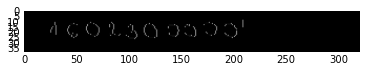

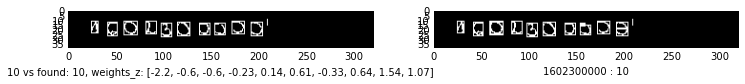

In [170]:
# NOTE: This section contains entire pipeline without much function delegation for debuging purposes


# BUg:
# 1602300000_ae61d5.png
# i = 2509
# # # ERROR in third projection used for splitting
# horizontal noise filter removing all digits
# solution: 
# works awesome with process_projection_peaks(project, threshold=0.75)
# Y THRESH 0.56 disappear
# Y THRESH 0.57 works!

img = cv2.imread("regions/1602300000_ae61d5.png")
label = "1602300000"
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh, blur_img = image_augmentation_pipeline(gray)
# plt.imshow(thresh, cmap="gray")
# plt.imshow(blur_img, cmap="gray")
# boxes = get_digit_bounding_boxes(thresh, blur_img, debug=False)
masked = np.copy(thresh)
###
# y axis projection
###


project_img, mask_img = blur_img, masked

project = np.sum(project_img, axis=1)
peaks, peak_widths_l, peak_base_heights, starts, ends = process_projection_peaks(project, threshold=0.57)

mx_w_ind = np.argmax(peak_widths_l)
st, en = starts[mx_w_ind], ends[mx_w_ind]

# masked = np.copy(thresh)
mask_img[:st, :] = 0
mask_img[en:, :] = 0
###
# x axis projection
###
filter_vertical_noise_xaxis_projection(blur_img, masked)
plt.imshow(masked, cmap="gray")



clone_masked = masked.copy() # used in box_split_routine

pyplot_axis_res = None
pyplot_axis_prev = None

for i, axes in gen_subplot_group(1*2, size=1.0, yield_group=2):
        pyplot_axis_res, pyplot_axis_prev = axes
    
debug = True

if debug:
    box_filtered = masked.copy() # for drawing bounding boxes
    clone = masked.copy()
    # DEBUG: draw_img: used to compare boxes found, used in get_contour_bounding_boxes
    # TODO: try drawing boxes on gaussian Blurred image instead of thresholded image
    boxes = get_contour_bounding_boxes(masked, draw_img=clone)
else:
    boxes = get_contour_bounding_boxes(masked)

# ALPHA TEST
bbs = list(map(MergedBox, boxes))
bbs = box_merge_routines(bbs)
###
# Box SPLIT routines: canny peaks counts/importance, box width Gauss filter
###
bbs = box_split_routine(clone_masked, bbs)

cut_imgs = []

for box in bbs:
    cut_imgs.append(box.cut_from_image(clone_masked))


if debug:

    # DEBUG: image labels
    bbs.sort(key=lambda x: x.area(), reverse=False)
    from scipy import stats
    import math
    peak_counts_s = "{} vs found: {}, weights_z: {}".format(len(label), str(len(bbs)), list(map(lambda x: math.ceil(x*100)/100, stats.zscore(list(map(lambda x: x.varea(), bbs))))))
    ###

    for box in bbs:
        (x, y, w, h) = box.box
        cv2.rectangle(box_filtered, (x,y), (x+w, y+h), (255, 0, 0), 1)
    ##########  

#     pyplot_axis.imshow(clone, cmap="gray")
#     pyplot_axis.set_xlabel(labels[i] + " : {}".format(len(labels[i])))
#     pyplot_axis.set_ylabel("boxes ori")

    pyplot_axis_res.imshow(box_filtered, cmap="gray")
    pyplot_axis_res.set_xlabel(peak_counts_s)

    pyplot_axis_prev.imshow(clone, cmap="gray") # clone, thresh
    pyplot_axis_prev.set_xlabel(label + " : {}".format(len(label)))


/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rbhack/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


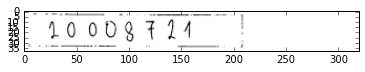

In [160]:

img = cv2.imread("regions/20008721_64cc7e.png")
plt.imshow(img)
label = "20008721"
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
cut_imgs = get_separated_digits(gray)

(33, 70)
0
1
2
3
20008721


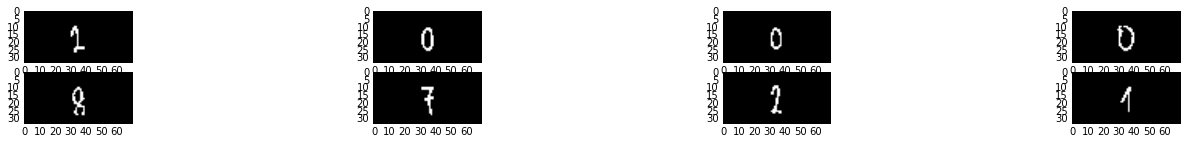

In [159]:
print(cut_imgs[6].shape)

for i, axes in gen_subplot_group(len(cut_imgs), cols=len(cut_imgs)//2, size=1.0, colsize=1.0, yield_group=2):
    print(i)
    for j, ax in enumerate(axes):
        ax.imshow(cut_imgs[i*2+j], cmap="gray")
    
print(label)